In [1]:
import pandas as pd
import numpy as np
import xarray as xr

import os
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from src.helpers import *
from src.visualize import *
from src.trainer import *
from Models.models import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import *
from copy import deepcopy
import torch.utils.data as data
from torch.utils.data import Dataset

import pickle
import math

/home/nerea/anaconda3/envs/sinthlab/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
sys.path.append("c:\\Users\\nerea\\OneDrive\\Documentos\\EPFL_MASTER\\PDM\\Project\\PyalData")
# to change for the actual path where PyalData has been cloned

In [3]:
from pyaldata import *

In [4]:
#@title Helper functions for plotting (run this cell!)
sns.set_context("notebook")

# initialize a color palette for plotting
palette = sns.xkcd_palette(["windows blue",
                            "red",
                            "medium green",
                            "dusty purple",
                            "orange",
                            "amber",
                            "clay",
                            "pink",
                            "greyish"])

## Load the data

In [5]:
data_dir = "./Data"
#fname = os.path.join(data_dir, "Sansa_20180507.mat") #--> only 7 baseline reaches
fname = os.path.join(data_dir, "Sansa_20180413.mat")

In [6]:
# load TrialData .mat file into a DataFrame
group_df = mat2dataframe(fname, shift_idx_fields=True, td_name='grp')

array field StimParamNames could not be converted to int.


/home/nerea/CL_UpperLimb_Control/./PyalData/pyaldata/data_cleaning.py:68: RuntimeWarning: invalid value encountered in cast
  int_arrays = [np.int32(arr) for arr in df[field]]


In [7]:
# trial_df = mat2dataframe_NC(fname, shift_idx_fields=True, td_name = 'trial_data') --> works with data from 07/05
trial_df = mat2dataframe_NC(fname, shift_idx_fields=True, td_name = 'trial_data') 

array field kin_names could not be converted to int.
array field joint_names could not be converted to int.
array field stim_param_names could not be converted to int.


/home/nerea/CL_UpperLimb_Control/./PyalData/pyaldata/data_cleaning.py:68: RuntimeWarning: invalid value encountered in cast
  int_arrays = [np.int32(arr) for arr in df[field]]


The main dataframe here is trial_df, the group one will be used if needed to add some variables to the other one.

In [8]:
df = trial_df

`Note` Here not sure if there should be a combination of bins to make it longer and incude more spikes, but I will keep if as the demo, with now 20ms bins. 

#### **Combine time-bins into longer ones**

In [9]:
td = combine_time_bins(df, 2)
# now each bin corresponds to 20ms of recording.

#### **Remove low-firing neurons**

In [10]:
td = remove_low_firing_neurons(td, "M1_spikes",  5)
td = remove_low_firing_neurons(td, "PMd_spikes", 5)

print("original: ", df.M1_spikes[0].shape)
print("removed:  ", td.M1_spikes[0].shape)

original:  (5235, 64)
removed:   (2617, 64)


/home/nerea/CL_UpperLimb_Control/./PyalData/pyaldata/firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/nerea/CL_UpperLimb_Control/./PyalData/pyaldata/firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


#### **Transform signals**

In [11]:
td = transform_signal(td, "M1_spikes",  'sqrt')
td = transform_signal(td, "PMd_spikes", 'sqrt')
#here we change the motor and premotor cortex spikes by their square root

#### **Merge signals from multiple areas**

Signals from the pre-motor and motor cortex are now combines in one same variable, we do not consider the 2 regions as different but more as functionally working together.

In [12]:
td = merge_signals(td, ["M1_spikes", "PMd_spikes"], "both_spikes")

print(f"Merging M1 and PMd gives {td.M1_spikes[0].shape[1]} + {td.PMd_spikes[0].shape[1]} = {td.both_spikes[0].shape[1]} neurons")

Merging M1 and PMd gives 64 + 63 = 127 neurons


#### **Calculate firing rates from spikes**

In [13]:
# works on "_spikes" fields and automatically divides by bin_size
td = add_firing_rates(td, 'smooth')

#### **Keep only the successful trials**

#### For this part of the project we do not need perfect reach trials, only to decode the motor intention in baseline trials.

In [14]:
td['idx_end_complete'] = td.apply(lambda x: add_bad_idx(x['idx_end'], x['idx_bad']), axis=1)
# Apply the function to each row
td['bad_indices'] = td.apply(find_bad_indices, axis=1)

In [15]:
td_all = pd.concat([td,group_df.drop(columns = 'type')], axis = 1)

In [16]:
cols_to_search = ['index', 'num', 'type', 'tonic_stim_params','KUKAPos',
               'idx_kuka_go', 'idx_reach', 'idx_end_complete',
               'bad_indices', 'x', 'y', 'z', 'angles', 'both_spikes', 'both_rates']
cols_to_keep = [c for c in cols_to_search if c in td_all.columns]
td_filt = td_all[cols_to_keep]

In [17]:
#td_filt = td_filt.loc[td_filt.type == 'BASELINE'].reset_index()

In [18]:
td_filt['test_start'] = td_filt['idx_reach'].apply(lambda x: x[0])

/tmp/ipykernel_975164/918602067.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  td_filt['test_start'] = td_filt['idx_reach'].apply(lambda x: x[0])


In [19]:
td_filt['test_end'] = td_filt['idx_end_complete'].apply(lambda x: x[0])

/tmp/ipykernel_975164/1192183913.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  td_filt['test_end'] = td_filt['idx_end_complete'].apply(lambda x: x[0])


In [20]:
tidy_df = build_tidy_df(td_filt, start_margin = 5)

In [21]:
tidy_df['target_pos'] = tidy_df.apply(lambda x: np.concatenate([x['x'][4:5], x['y'][4:5], x['z'][4:5]]), axis = 1)

In [22]:
tidy_df['id'] = tidy_df['trial_num'].astype(str) + '_' + tidy_df['reach_num'].astype(str)

In [23]:
path_to_save_data = './Data/Processed_Data/Tidy_Sansa_13_04.pkl'

In [24]:
with open(path_to_save_data, 'wb') as handle:
            pickle.dump(tidy_df, handle, protocol=4)

In [25]:
baseline_df = tidy_df.loc[tidy_df.type == 'BASELINE'].reset_index()

In [26]:
stim_df = tidy_df.loc[tidy_df.type == 'TONIC'].reset_index()

In [27]:
baseline_df.id.unique()

array(['0_0', '0_1', '0_2', '0_3', '0_4', '7_0', '7_1', '7_2', '7_3',
       '7_4', '8_0', '8_1', '8_2', '8_3', '8_4', '11_0', '11_1', '11_2',
       '11_3', '11_4'], dtype=object)

In [28]:
X_train, y_train, X_val, y_val, X_test, y_test, info_train, info_val, info_test = train_test_split(baseline_df, train_variable = 'both_rates', 
                                                                                                   target_variable = 'target_pos', num_folds = 5)

Test trials  4
Val trials 3


In [29]:
# Test one of the folds first
fold_num = 'fold0'
fold = 0

print('We are testing the optimization method on fold ', fold)


X_train = X_train[fold_num]
X_val = X_val[fold_num]
X_test = X_test[fold_num]
y_test = y_test[fold_num]
y_train = y_train[fold_num]
y_val = y_val[fold_num]


# Specify that we want our tensors on the GPU and in float32
device = torch.device('cpu') #suposed to be cuda
dtype = torch.float32
path_to_models = './Models'

num_dim_output = y_train.shape[1]
num_features = X_train.shape[1]

seq_length = 75

# Reshape x_train to match the number of columns in the model's input layer
xx_train = X_train.reshape(X_train.shape[0] // seq_length, seq_length, X_train.shape[1])  
# Reshape y_train to match the number of neurons in the model's output layer
yy_train = y_train.reshape(y_train.shape[0] // seq_length, seq_length, y_train.shape[1])  

xx_val = X_val.reshape(X_val.shape[0] // seq_length, seq_length, X_val.shape[1])  
yy_val = y_val.reshape(y_val.shape[0] // seq_length, seq_length, y_val.shape[1])  

xx_test = X_test.reshape(X_test.shape[0] // seq_length, seq_length, X_test.shape[1])  
yy_test = y_test.reshape(y_test.shape[0] // seq_length, seq_length, y_test.shape[1])  

seed = 42
torch.manual_seed(seed)



We are testing the optimization method on fold  0


In [30]:
# Define hyperparameters

#Hyperparameters objective and regularization
alpha_reg = 1.21e-6
l1_ratio_reg = 0.394

lr = 0.00193
loss_function = huber_loss
delta = 8  # hyperparameter for huber loss

# Hyperparameters LSTM class
hidden_units = 29
num_layers = 4
input_size = 31
dropout_1 = 0.8346
dropout_2 = 0.6125

#Other training hyperparameters

lr_gamma= 1.437 #for scheduler
lr_step_size = 10 #for scheduler

seq_length_LSTM= 6
batch_size_train= 23
batch_size_val = 49

Reg = globals().get(Regularizer_LSTM)

In [31]:
# Fit the LSTM model
model = CausalTemporalLSTM(num_features=num_features, 
                    hidden_units= hidden_units, #was 128
                    num_layers = num_layers, 
                    input_size = input_size,
                    out_dims = num_dim_output, 
                    dropout_1 = dropout_1, 
                    dropout_2 = dropout_2).to(device)

In [32]:
train_losses, val_losses = \
    train_model(model, xx_train,yy_train,
                xx_val, 
                yy_val,
                lr= lr,
                lr_step_size=lr_step_size,
                lr_gamma= lr_gamma,
                sequence_length_LSTM=seq_length_LSTM,
                batch_size_train = batch_size_train,
                batch_size_val = batch_size_val,
                num_epochs=1000, 
                delta = 8,                 
                regularizer=Reg,
                l1_ratio = 0.5,
                alpha = 1e-5,     
                early_stop = 5,
                
                )


Epoch 000 Train 0.0320 Val 0.0370
Epoch 001 Train 0.0194 Val 0.0248
Epoch 002 Train 0.0141 Val 0.0217
Epoch 003 Train 0.0122 Val 0.0210
Epoch 004 Train 0.0116 Val 0.0208
Epoch 005 Train 0.0111 Val 0.0206
Epoch 006 Train 0.0105 Val 0.0208
Epoch 007 Train 0.0105 Val 0.0200
Epoch 008 Train 0.0103 Val 0.0202
Epoch 009 Train 0.0100 Val 0.0206
Epoch 010 Train 0.0098 Val 0.0199
Epoch 011 Train 0.0097 Val 0.0214
Epoch 012 Train 0.0095 Val 0.0208
Epoch 013 Train 0.0092 Val 0.0215
Epoch 014 Train 0.0090 Val 0.0234
Epoch 015 Train 0.0087 Val 0.0189
Epoch 016 Train 0.0083 Val 0.0207
Epoch 017 Train 0.0082 Val 0.0201
Epoch 018 Train 0.0077 Val 0.0231
Epoch 019 Train 0.0072 Val 0.0263
Decrease LR
Epoch 020 Train 0.0075 Val 0.0277
Epoch 021 Train 0.0068 Val 0.0280
Epoch 022 Train 0.0064 Val 0.0257
Epoch 023 Train 0.0064 Val 0.0254
Epoch 024 Train 0.0062 Val 0.0248
Decrease LR


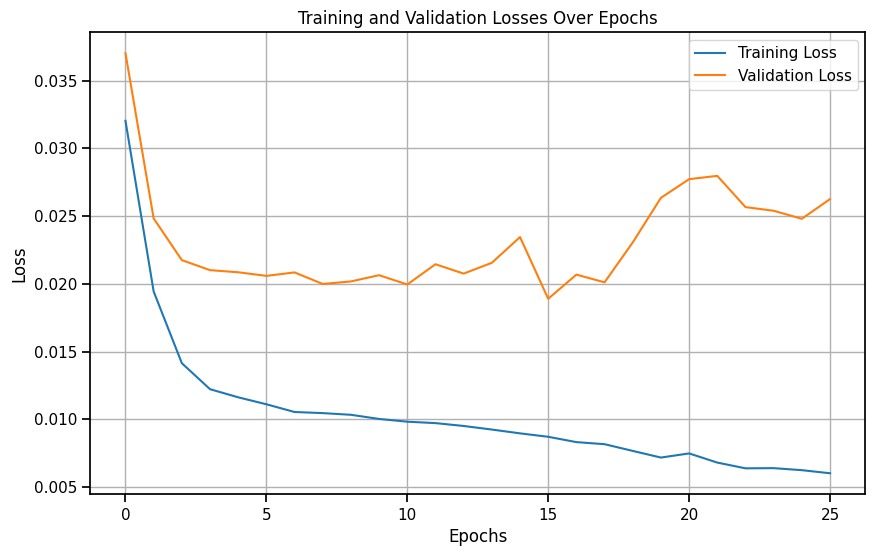

In [33]:
# Assuming you have already trained your model and collected the losses
# train_losses and val_losses are numpy arrays containing losses for each epoch
plot_losses(train_losses, val_losses)

In [34]:
path_to_models = './Models'
experiment_name = 'LSTM_fold0_20180413_Baseline'
path_to_save_model = os.path.join(path_to_models,experiment_name)
if not os.path.exists(path_to_save_model):
            os.makedirs(path_to_save_model)
path_to_save_model_fold = os.path.join(path_to_save_model,'fold_{}.pth'.format(fold))
torch.save(model, path_to_save_model_fold)
dict_loss = {}
dict_loss['train'] = train_losses
dict_loss['val'] = val_losses
path_to_save_model_losses = os.path.join(path_to_save_model,'loss_fold_{}.p'.format(fold))
with open(path_to_save_model_losses, 'wb') as handle:
    pickle.dump(dict_loss, handle, protocol=4)

In [35]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train, yy_train, xx_val, yy_val, xx_test, yy_test, model, metric = 'ev')

Train EV: 0.71 
Val EV: 0.54 
Test EV: 0.55 


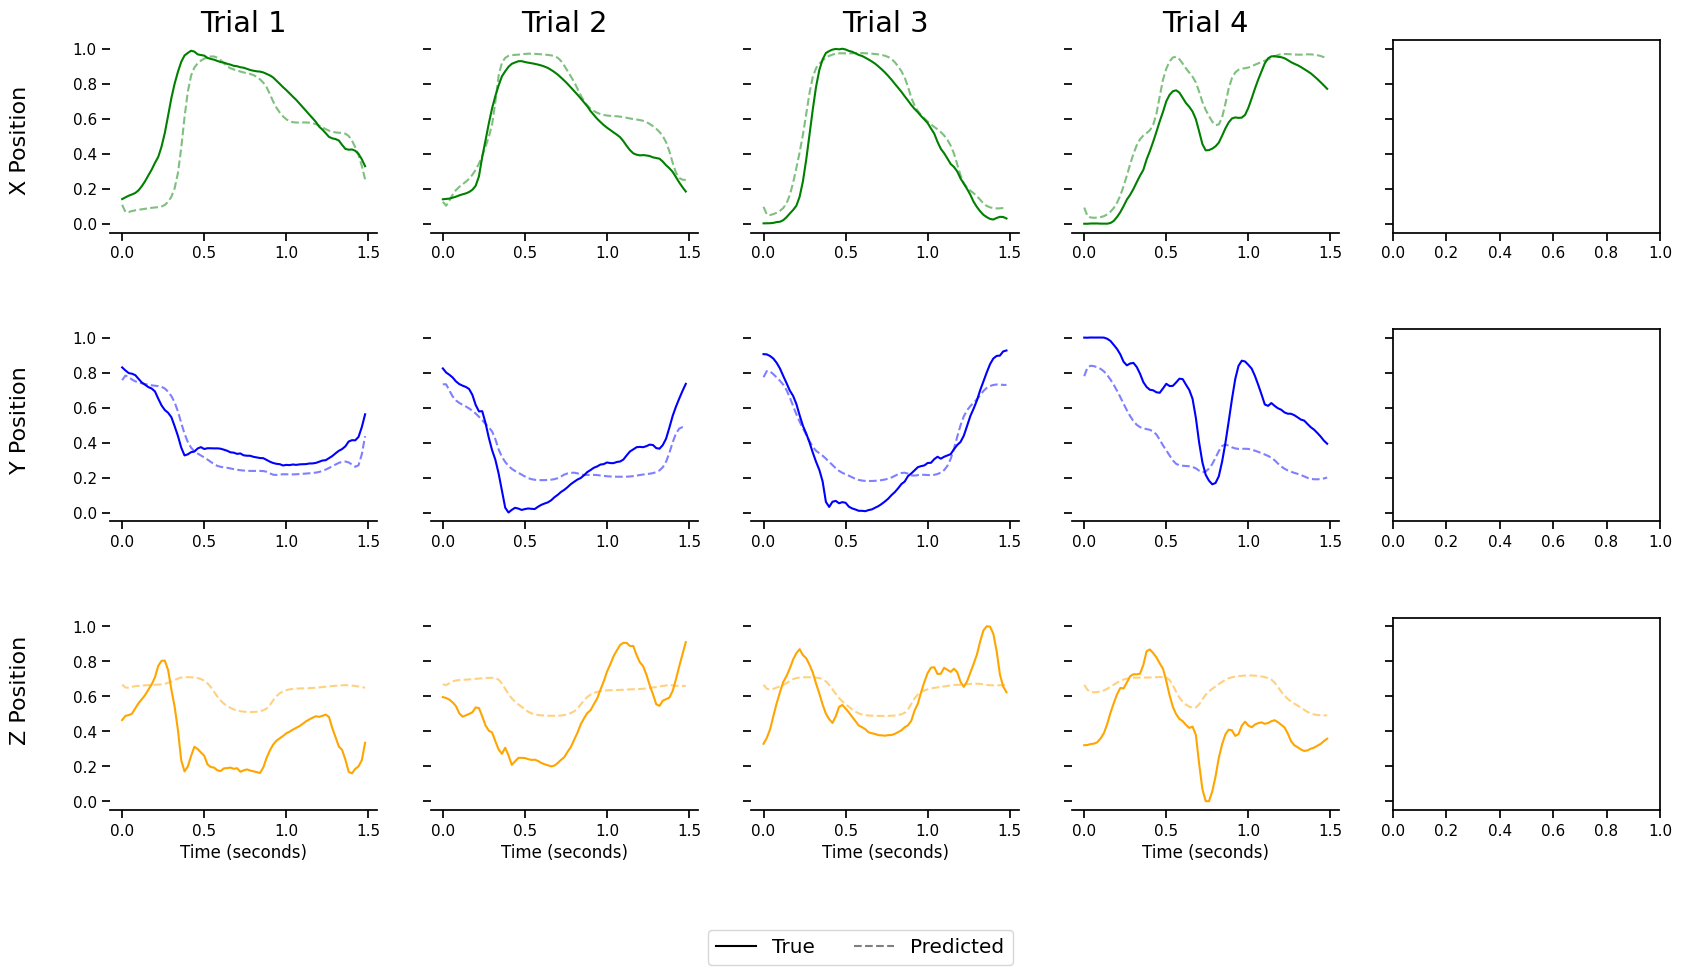

In [36]:
visualize_LSTM_test(y_hat, y_true, seq_length = 75)

## Testing the model on stimulation data

In [37]:
X_train_stim, y_train_stim, X_val_stim,y_val_stim, X_test_stim, y_test_stim, info_train_stim,info_val_stim, info_test_stim = train_test_split(stim_df, train_variable = 'both_rates', 
                                                 target_variable = 'target_pos', num_folds = 5)

Test trials  8
Val trials 7


In [38]:
# Test one of the folds first
fold_num = 'fold0'
fold = 0

print('We are testing the model on fold ', fold)


X_train_stim = X_train_stim[fold_num]
X_val_stim = X_val_stim[fold_num]
X_test_stim = X_test_stim[fold_num]
y_test_stim = y_test_stim[fold_num]
y_train_stim = y_train_stim[fold_num]
y_val_stim = y_val_stim[fold_num]


# Specify that we want our tensors on the GPU and in float32
device = torch.device('cpu') #suposed to be cuda
dtype = torch.float32
path_to_models = './Models'

num_dim_output = y_train_stim.shape[1]
num_features = X_train_stim.shape[1]

seq_length = 75

# Reshape x_train to match the number of columns in the model's input layer
xx_train = X_train_stim.reshape(X_train_stim.shape[0] // seq_length, seq_length, X_train_stim.shape[1])  
# Reshape y_train to match the number of neurons in the model's output layer
yy_train = y_train_stim.reshape(y_train_stim.shape[0] // seq_length, seq_length, y_train_stim.shape[1])  

xx_val = X_val_stim.reshape(X_val_stim.shape[0] // seq_length, seq_length, X_val_stim.shape[1])  
yy_val = y_val_stim.reshape(y_val_stim.shape[0] // seq_length, seq_length, y_val_stim.shape[1])  

xx_test = X_test_stim.reshape(X_test_stim.shape[0] // seq_length, seq_length, X_test_stim.shape[1])  
yy_test = y_test_stim.reshape(y_test_stim.shape[0] // seq_length, seq_length, y_test_stim.shape[1])  

We are testing the model on fold  0


In [39]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train, yy_train, xx_val, yy_val, xx_test, yy_test, model, metric = 'ev')

Train EV: 0.39 
Val EV: 0.53 
Test EV: 0.23 


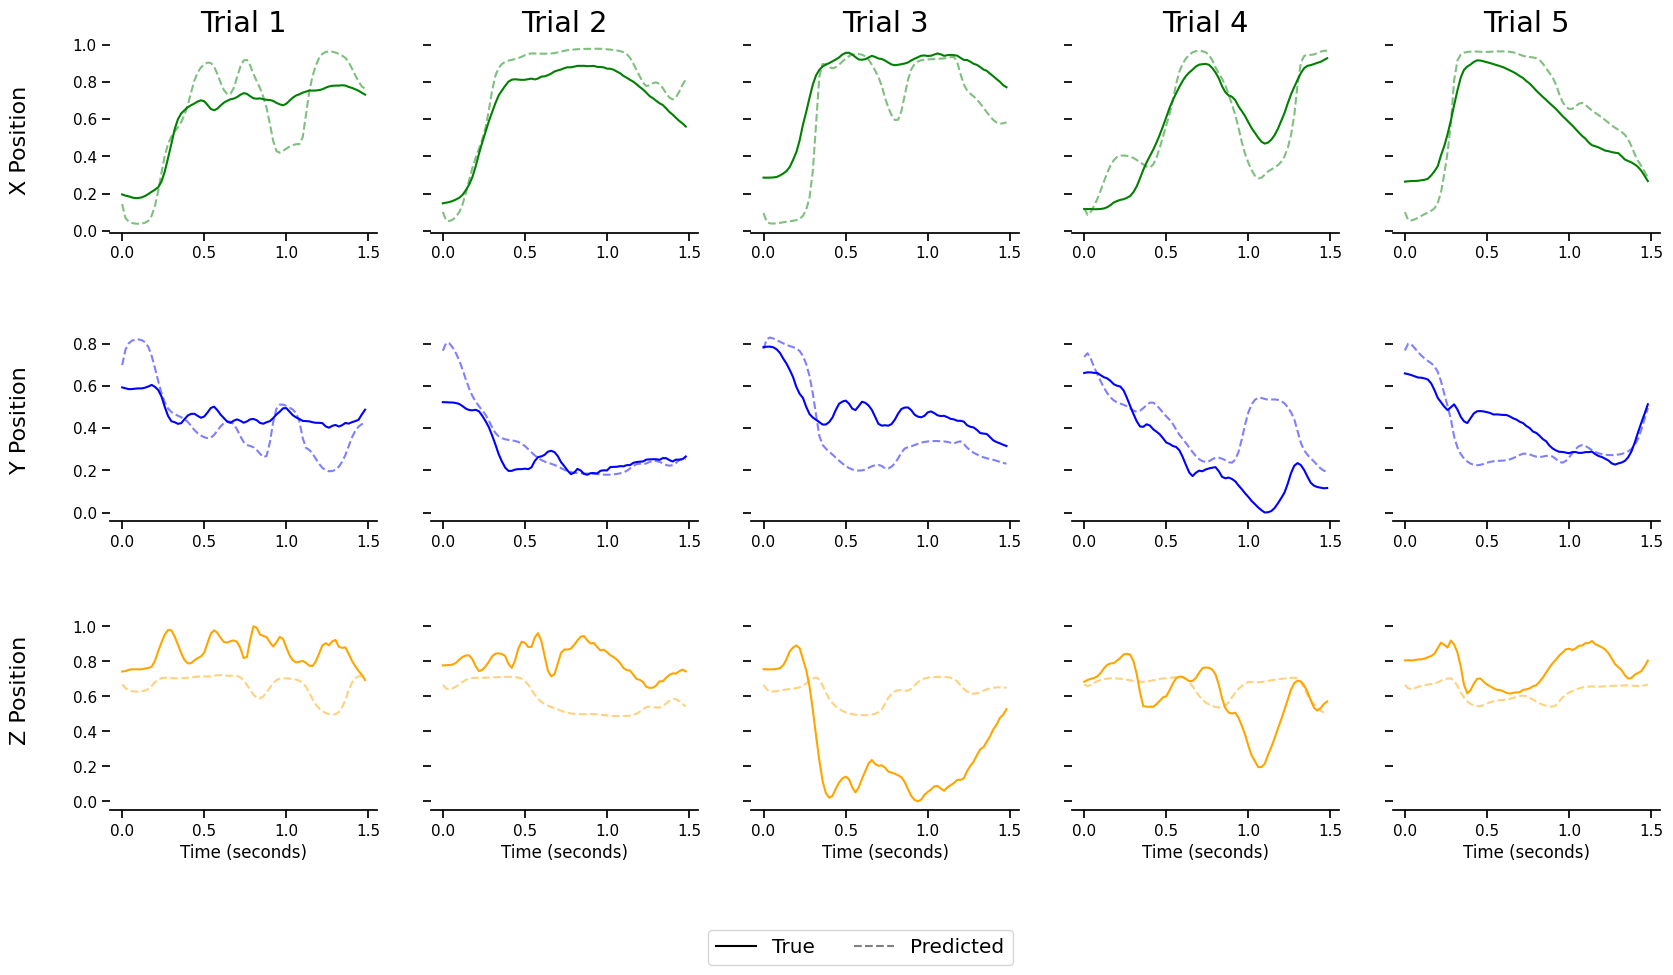

In [40]:
visualize_LSTM_test(y_hat, y_true, seq_length = 75)

## Now we use all data for training

In [41]:
X_train, y_train, X_val, y_val, X_test, y_test, info_train, info_val, info_test = train_test_split(tidy_df, train_variable = 'both_rates', 
                                                                                                   target_variable = 'target_pos', num_folds = 5)

Test trials  12
Val trials 10


In [42]:
# Test one of the folds first
fold_num = 'fold0'
fold = 0

print('We are testing the optimization method on fold ', fold)


X_train = X_train[fold_num]
X_val = X_val[fold_num]
X_test = X_test[fold_num]
y_test = y_test[fold_num]
y_train = y_train[fold_num]
y_val = y_val[fold_num]


# Specify that we want our tensors on the GPU and in float32
device = torch.device('cpu') #suposed to be cuda
dtype = torch.float32
path_to_models = './Models'

num_dim_output = y_train.shape[1]
num_features = X_train.shape[1]

seq_length = 75

# Reshape x_train to match the number of columns in the model's input layer
xx_train = X_train.reshape(X_train.shape[0] // seq_length, seq_length, X_train.shape[1])  
# Reshape y_train to match the number of neurons in the model's output layer
yy_train = y_train.reshape(y_train.shape[0] // seq_length, seq_length, y_train.shape[1])  

xx_val = X_val.reshape(X_val.shape[0] // seq_length, seq_length, X_val.shape[1])  
yy_val = y_val.reshape(y_val.shape[0] // seq_length, seq_length, y_val.shape[1])  

xx_test = X_test.reshape(X_test.shape[0] // seq_length, seq_length, X_test.shape[1])  
yy_test = y_test.reshape(y_test.shape[0] // seq_length, seq_length, y_test.shape[1])  

seed = 42
torch.manual_seed(seed)



We are testing the optimization method on fold  0


In [43]:
# Define hyperparameters

#Hyperparameters objective and regularization
alpha_reg = 1e-5
l1_ratio_reg = 0.5

lr = 0.0001
loss_function = huber_loss
delta = 8  # hyperparameter for huber loss

# Hyperparameters LSTM class
hidden_units = 43
num_layers = 1
input_size = 50
dropout_1 = 0.5
dropout_2 = 0.5

#Other training hyperparameters

lr_gamma= 1.4 #for scheduler
lr_step_size = 10 #for scheduler

seq_length_LSTM= 19
batch_size_train= 25
batch_size_val = 25

Reg = globals().get(Regularizer_LSTM)

In [44]:
# Fit the LSTM model
model = CausalTemporalLSTM(num_features=num_features, 
                    hidden_units= hidden_units, #was 128
                    num_layers = num_layers, 
                    input_size = input_size,
                    out_dims = num_dim_output, 
                    dropout_1 = dropout_1, 
                    dropout_2 = dropout_2).to(device)
def weight_reset(m):
    reset_parameters = getattr(m, "reset_parameters", None)
    if callable(reset_parameters):
        m.reset_parameters()

model.apply(weight_reset)

CausalTemporalLSTM(
  (lstm): LSTM(50, 43, batch_first=True)
  (linear1): Linear(in_features=127, out_features=50, bias=True)
  (linear2): Linear(in_features=43, out_features=3, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
)

In [45]:
train_losses, val_losses = \
    train_model(model, xx_train,yy_train,
                xx_val, 
                yy_val,
                lr= lr,
                lr_step_size=lr_step_size,
                lr_gamma= lr_gamma,
                sequence_length_LSTM=seq_length_LSTM,
                batch_size_train = batch_size_train,
                batch_size_val = batch_size_val,
                num_epochs=1000, 
                delta = 8,                 
                regularizer=Reg,
                l1_ratio = 0.5,
                alpha = 1e-5,     
                early_stop = 5,
                
                )


Epoch 000 Train 0.0290 Val 0.0234
Epoch 001 Train 0.0190 Val 0.0163
Epoch 002 Train 0.0131 Val 0.0141
Epoch 003 Train 0.0110 Val 0.0132
Epoch 004 Train 0.0099 Val 0.0127
Epoch 005 Train 0.0089 Val 0.0122
Epoch 006 Train 0.0080 Val 0.0119
Epoch 007 Train 0.0072 Val 0.0115
Epoch 008 Train 0.0066 Val 0.0116
Epoch 009 Train 0.0062 Val 0.0117
Epoch 010 Train 0.0058 Val 0.0119
Epoch 011 Train 0.0055 Val 0.0119
Epoch 012 Train 0.0052 Val 0.0120
Epoch 013 Train 0.0050 Val 0.0120
Epoch 014 Train 0.0048 Val 0.0122
Decrease LR
Epoch 015 Train 0.0046 Val 0.0123
Epoch 016 Train 0.0045 Val 0.0122
Epoch 017 Train 0.0044 Val 0.0123
Epoch 018 Train 0.0043 Val 0.0123
Epoch 019 Train 0.0042 Val 0.0122
Decrease LR


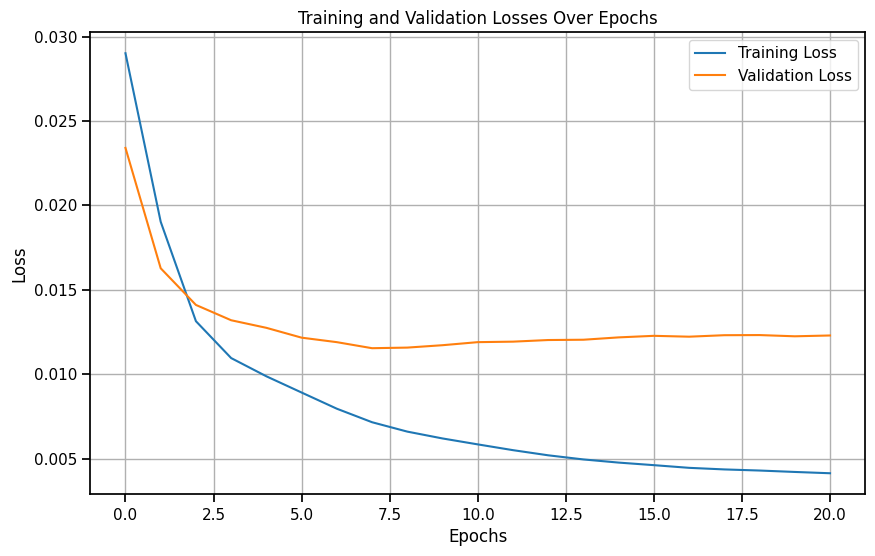

In [46]:
# Assuming you have already trained your model and collected the losses
# train_losses and val_losses are numpy arrays containing losses for each epoch
plot_losses(train_losses, val_losses)

In [47]:
path_to_models = './Models'
experiment_name = 'LSTM_fold0_20180413_Baseline'
path_to_save_model = os.path.join(path_to_models,experiment_name)
if not os.path.exists(path_to_save_model):
            os.makedirs(path_to_save_model)
path_to_save_model_fold = os.path.join(path_to_save_model,'fold_{}.pth'.format(fold))
torch.save(model, path_to_save_model_fold)
dict_loss = {}
dict_loss['train'] = train_losses
dict_loss['val'] = val_losses
path_to_save_model_losses = os.path.join(path_to_save_model,'loss_fold_{}.p'.format(fold))
with open(path_to_save_model_losses, 'wb') as handle:
    pickle.dump(dict_loss, handle, protocol=4)

In [48]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train, yy_train, xx_val, yy_val, xx_test, yy_test, model, metric = 'ev')

Train EV: 0.79 
Val EV: 0.56 
Test EV: 0.48 


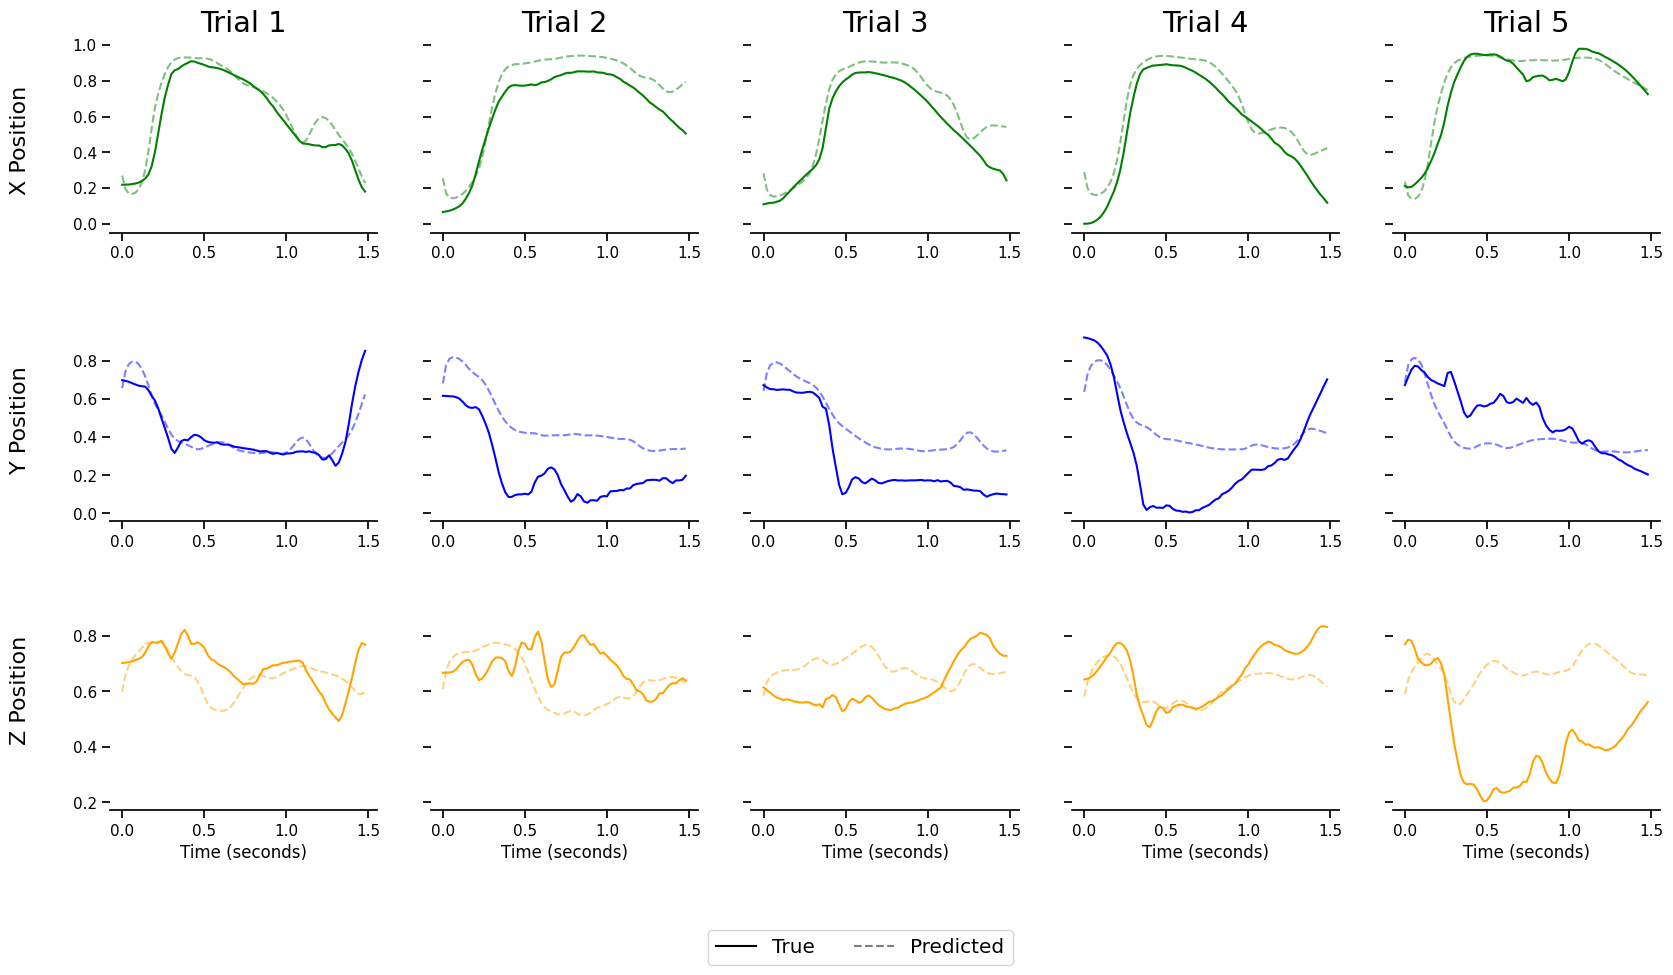

In [49]:
visualize_LSTM_test(y_hat, y_true, seq_length = 75)

## Implementing EWC

In [50]:
def get_ewc_loss(model, fisher, p_old):
    loss = 0
    for n, p in model.named_parameters():
        _loss = fisher[n] * (p - p_old[n]) ** 2
        loss += _loss.sum()
    return loss

In [51]:
model = torch.load(path_to_save_model_fold)
model.eval()


CausalTemporalLSTM(
  (lstm): LSTM(50, 43, batch_first=True)
  (linear1): Linear(in_features=127, out_features=50, bias=True)
  (linear2): Linear(in_features=43, out_features=3, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
)

In [52]:
X_train, y_train, X_val, y_val, X_test, y_test, info_train, info_val, info_test = train_test_split(baseline_df, train_variable = 'both_rates', 
                                                                                                   target_variable = 'target_pos', num_folds = 5)

Test trials  4
Val trials 3


In [53]:
# Test one of the folds first
fold_num = 'fold0'
fold = 0

print('We are testing the optimization method on fold ', fold)


X_train = X_train[fold_num]
X_val = X_val[fold_num]
X_test = X_test[fold_num]
y_test = y_test[fold_num]
y_train = y_train[fold_num]
y_val = y_val[fold_num]


# Specify that we want our tensors on the GPU and in float32
device = torch.device('cpu') #suposed to be cuda
dtype = torch.float32
path_to_models = './Models'

num_dim_output = y_train.shape[1]
num_features = X_train.shape[1]

seq_length = 75

# Reshape x_train to match the number of columns in the model's input layer
xx_train = X_train.reshape(X_train.shape[0] // seq_length, seq_length, X_train.shape[1])  
# Reshape y_train to match the number of neurons in the model's output layer
yy_train = y_train.reshape(y_train.shape[0] // seq_length, seq_length, y_train.shape[1])  

xx_val = X_val.reshape(X_val.shape[0] // seq_length, seq_length, X_val.shape[1])  
yy_val = y_val.reshape(y_val.shape[0] // seq_length, seq_length, y_val.shape[1])  

xx_test = X_test.reshape(X_test.shape[0] // seq_length, seq_length, X_test.shape[1])  
yy_test = y_test.reshape(y_test.shape[0] // seq_length, seq_length, y_test.shape[1])  

seed = 42
torch.manual_seed(seed)



We are testing the optimization method on fold  0


In [54]:
to_t_eval =  lambda array: torch.tensor(array, device='cpu', dtype=dtype)  
x = to_t_eval(xx_train) 
y = to_t_eval(yy_train)

In [55]:
# Assuming X_train and y_train are NumPy arrays or PyTorch tensors
dataset = list(zip(x, y))

In [56]:
params = {n: p for n, p in model.named_parameters() if p.requires_grad}
p_old = {}

for n, p in deepcopy(params).items():
    p_old[n] = p.data

In [57]:
def get_fisher_diag(model, dataset, params, empirical=True):
    fisher = {}
    for n, p in deepcopy(params).items():
        p.data.zero_()
        fisher[n] = p.data

    model.eval()
    for input, gt_label in dataset:
        model.zero_grad()
        output = model(input).view(-1)
        if empirical:
            label = gt_label.view(-1)
            
        else:
            label = output.max(1)[1].view(-1)
            

        h_loss  = huber_loss(output, label)
        #negloglikelihood = F.nll_loss(F.log_softmax(output, dim = -1), label)
        #negloglikelihood.backward()
        h_loss.backward()

        for n, p in model.named_parameters():
            fisher[n].data += p.grad.data ** 2 / len(dataset)

    fisher = {n: p for n, p in fisher.items()}
    return fisher

In [58]:
fisher_matrix = get_fisher_diag(model, dataset, params)

In [59]:
def train_model_EWC(model, X,Y,
                X_val, 
                Y_val,
                lr=0.0001,
                lr_step_size=10,
                lr_gamma=0.9,
                sequence_length_LSTM=10,
                batch_size_train = 3,
                batch_size_val = 3,
                num_epochs=1000, 
                delta = 8,                 
                regularizer=None,
                l1_ratio = 0.5,
                alpha = 1e-5,     
                early_stop = 5,
                lambda_ewc = 0.2):

    # Set up the optimizer with the specified learning rate
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Set up a learning rate scheduler
    scheduler = lr_scheduler.StepLR(optimizer, 
                                    step_size=lr_step_size, 
                                    gamma=lr_gamma)
    
    
        
    # Keep track of the best model's parameters and loss
    best_model_wts = deepcopy(model.state_dict())
    best_loss = 1e8

    # Enable anomaly detection for debugging
    torch.autograd.set_detect_anomaly(True)

    # Track the train and validation loss
    train_losses = []
    val_losses = []
    # Counters for early stopping
    not_increased = 0
    end_train = 0
    
    # Reshape data for the LSTM
    train_dataset = SequenceDataset(
    Y,    X,    sequence_length=sequence_length_LSTM)

    val_dataset = SequenceDataset(
    Y_val,    X_val,    sequence_length=sequence_length_LSTM)
    loader_train = data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
    loader_val = data.DataLoader(val_dataset, batch_size=batch_size_val, shuffle=True)

    # Loop through epochs
    for epoch in np.arange(num_epochs):
        for phase in ['train', 'val']:
            # set model to train/validation as appropriate
            if phase == 'train':
                model.train()
                loader = loader_train
            else:
                model.eval()
                loader = loader_val

            # Initialize variables to track loss and batch size
            running_loss = 0
            running_size = 0        

            # Iterate over batches in the loader
            for X_, y_ in loader:
                #X_ = X_.to('cuda')
                #y_ = y_.to('cuda')
                if phase == "train":
                    with torch.set_grad_enabled(True):
                        optimizer.zero_grad()

                        output_t = model(X_)
                        output_t = torch.squeeze(output_t)


                        loss_t = huber_loss(output_t, y_, delta = delta)
                        
                        
                        # Add regularization to the loss in the training phase
                        if regularizer is not None:
                            ewc_loss = get_ewc_loss(model, fisher_matrix, p_old)
                            loss_t += lambda_ewc * ewc_loss
                        #     loss += regularizer(model, l1_ratio, alpha)
                        # Compute gradients and perform an optimization step
                        loss_t.backward(retain_graph=True)
                        optimizer.step()
                else:
                    # just compute the loss in validation phase
                    output_t = model(X_)
                    output_t = torch.squeeze(output_t)

                    loss_t = huber_loss(output_t, y_, delta = delta)
                    

                # Ensure the loss is finite
                assert torch.isfinite(loss_t)
                running_loss += loss_t.item()
                running_size += 1

            # compute the train/validation loss and update the best
            # model parameters if this is the lowest validation loss yet
            running_loss /= running_size
            if phase == "train":
                train_losses.append(running_loss)
            else:
                val_losses.append(running_loss)
                # Update best model parameters if validation loss improves
                if running_loss < best_loss:
                    best_loss = running_loss
                    best_model_wts = deepcopy(model.state_dict())
                    not_increased = 0
                else:
                    # Perform early stopping if validation loss doesn't improve
                    if epoch > 10:
                        not_increased += 1
                        # print('Not increased : {}/5'.format(not_increased))
                        if not_increased == early_stop:
                            print('Decrease LR')
                            for g in optimizer.param_groups:
                                g['lr'] = g['lr'] / 2
                            not_increased = 0
                            end_train += 1
                        
                        if end_train == 2:
                            model.load_state_dict(best_model_wts)
                            return np.array(train_losses), np.array(val_losses)

        # Update learning rate with the scheduler
        scheduler.step()
        print("Epoch {:03} Train {:.4f} Val {:.4f}".format(epoch, train_losses[-1], val_losses[-1]))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return np.array(train_losses), np.array(val_losses)

In [60]:
X_train_stim, y_train_stim, X_val_stim,y_val_stim, X_test_stim, y_test_stim, info_train_stim,info_val_stim, info_test_stim = train_test_split(stim_df, train_variable = 'both_rates', 
                                                 target_variable = 'target_pos', num_folds = 5)


Test trials  8
Val trials 7


In [61]:
# Test one of the folds first
fold_num = 'fold0'
fold = 0

print('We are testing the model on fold ', fold)


X_train_stim = X_train_stim[fold_num]
X_val_stim = X_val_stim[fold_num]
X_test_stim = X_test_stim[fold_num]
y_test_stim = y_test_stim[fold_num]
y_train_stim = y_train_stim[fold_num]
y_val_stim = y_val_stim[fold_num]


# Specify that we want our tensors on the GPU and in float32
device = torch.device('cpu') #suposed to be cuda
dtype = torch.float32
path_to_models = './Models'

num_dim_output = y_train_stim.shape[1]
num_features = X_train_stim.shape[1]

seq_length = 75

# Reshape x_train to match the number of columns in the model's input layer
xx_train = X_train_stim.reshape(X_train_stim.shape[0] // seq_length, seq_length, X_train_stim.shape[1])  
# Reshape y_train to match the number of neurons in the model's output layer
yy_train = y_train_stim.reshape(y_train_stim.shape[0] // seq_length, seq_length, y_train_stim.shape[1])  

xx_val = X_val_stim.reshape(X_val_stim.shape[0] // seq_length, seq_length, X_val_stim.shape[1])  
yy_val = y_val_stim.reshape(y_val_stim.shape[0] // seq_length, seq_length, y_val_stim.shape[1])  

xx_test = X_test_stim.reshape(X_test_stim.shape[0] // seq_length, seq_length, X_test_stim.shape[1])  
yy_test = y_test_stim.reshape(y_test_stim.shape[0] // seq_length, seq_length, y_test_stim.shape[1])  

We are testing the model on fold  0


In [62]:
train_losses, val_losses = \
    train_model_EWC(model, xx_train,yy_train,
                xx_val, 
                yy_val,
                lr= lr,
                lr_step_size=lr_step_size,
                lr_gamma= lr_gamma,
                sequence_length_LSTM=seq_length_LSTM,
                batch_size_train = batch_size_train,
                batch_size_val = batch_size_val,
                num_epochs=1000, 
                delta = 8,                 
                regularizer=None,
                l1_ratio = 0.5,
                alpha = 1e-5,     
                early_stop = 5,
                lambda_ewc = 0.2
                )


Epoch 000 Train 0.0088 Val 0.0178
Epoch 001 Train 0.0080 Val 0.0187
Epoch 002 Train 0.0075 Val 0.0187
Epoch 003 Train 0.0071 Val 0.0190
Epoch 004 Train 0.0067 Val 0.0198
Epoch 005 Train 0.0064 Val 0.0198
Epoch 006 Train 0.0061 Val 0.0201
Epoch 007 Train 0.0058 Val 0.0201
Epoch 008 Train 0.0056 Val 0.0202
Epoch 009 Train 0.0054 Val 0.0205
Epoch 010 Train 0.0052 Val 0.0206
Epoch 011 Train 0.0050 Val 0.0206
Epoch 012 Train 0.0048 Val 0.0206
Epoch 013 Train 0.0047 Val 0.0206
Epoch 014 Train 0.0045 Val 0.0207
Decrease LR
Epoch 015 Train 0.0044 Val 0.0203
Epoch 016 Train 0.0043 Val 0.0204
Epoch 017 Train 0.0042 Val 0.0204
Epoch 018 Train 0.0042 Val 0.0205
Epoch 019 Train 0.0041 Val 0.0204
Decrease LR


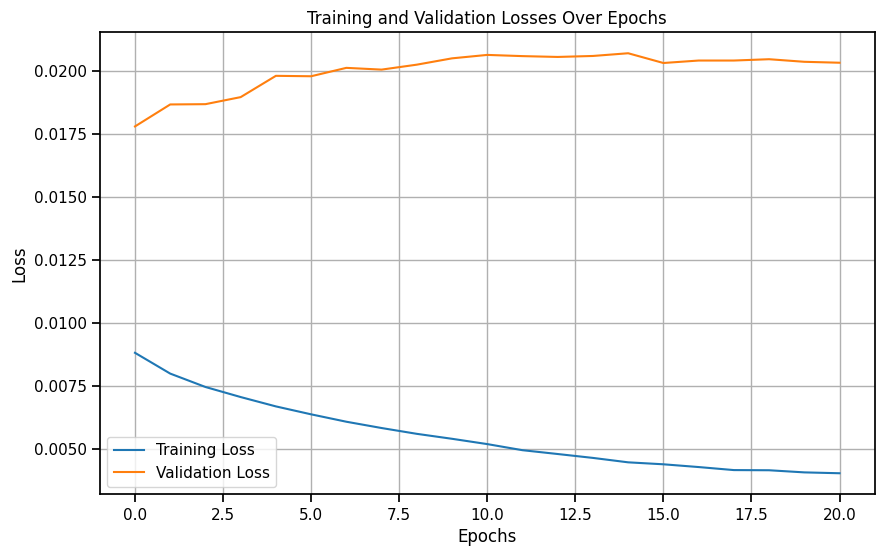

In [63]:
# Assuming you have already trained your model and collected the losses
# train_losses and val_losses are numpy arrays containing losses for each epoch
plot_losses(train_losses, val_losses)

In [64]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train, yy_train, xx_val, yy_val, xx_test, yy_test, model, metric = 'ev')

Train EV: 0.78 
Val EV: 0.61 
Test EV: 0.53 


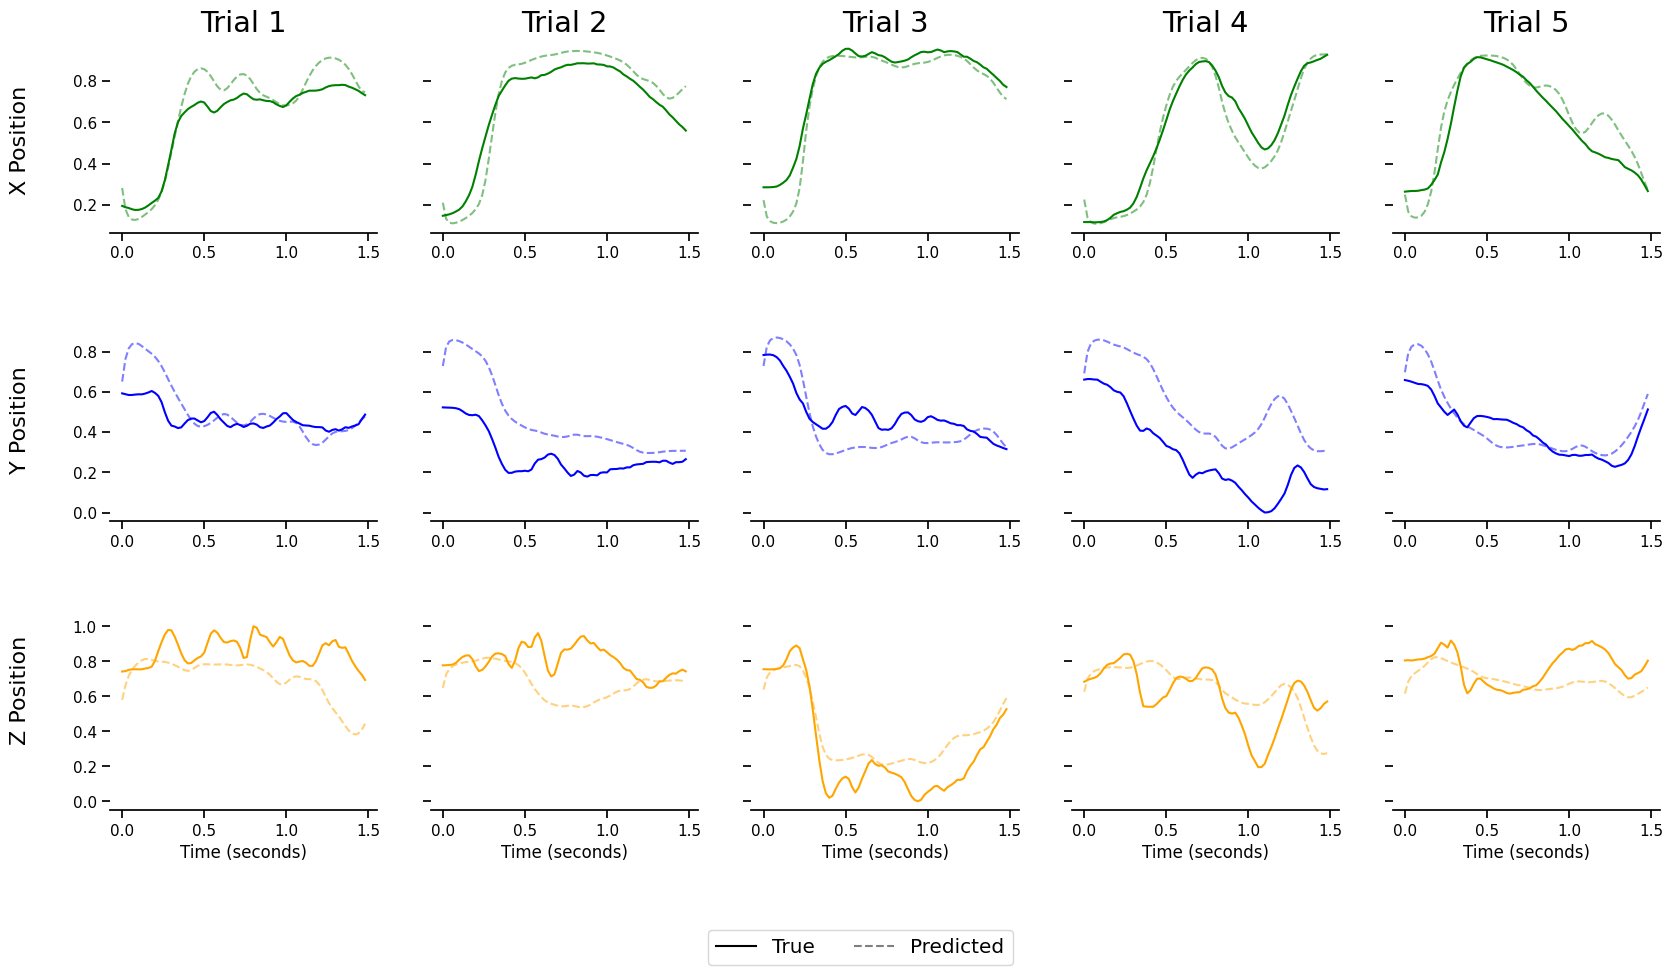

In [65]:
visualize_LSTM_test(y_hat, y_true, seq_length = 75)

In [66]:
path_to_models = './Models'
experiment_name = 'LSTM_fold0_20180413_Stim_EWC'
path_to_save_model = os.path.join(path_to_models,experiment_name)
if not os.path.exists(path_to_save_model):
            os.makedirs(path_to_save_model)
path_to_save_model_fold = os.path.join(path_to_save_model,'fold_{}.pth'.format(fold))
torch.save(model, path_to_save_model_fold)

### Testing the performance of the model on Baseline data after EWC

In [67]:
model_EWC = torch.load(path_to_save_model_fold)

In [68]:
model_EWC.eval()

CausalTemporalLSTM(
  (lstm): LSTM(50, 43, batch_first=True)
  (linear1): Linear(in_features=127, out_features=50, bias=True)
  (linear2): Linear(in_features=43, out_features=3, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
)

In [69]:
X_train, y_train, X_val, y_val, X_test, y_test, info_train, info_val, info_test = train_test_split(baseline_df, train_variable = 'both_rates', 
                                                 target_variable = 'target_pos', num_folds = 5)

Test trials  4
Val trials 3


In [70]:
# Test one of the folds first
fold_num = 'fold0'
fold = 0

print('We are testing the model on fold ', fold)


X_train = X_train[fold_num]
X_val = X_val[fold_num]
X_test = X_test[fold_num]
y_test = y_test[fold_num]
y_train = y_train[fold_num]
y_val = y_val[fold_num]


# Specify that we want our tensors on the GPU and in float32
device = torch.device('cpu') #suposed to be cuda
dtype = torch.float32
path_to_models = './Models'

num_dim_output = y_train.shape[1]
num_features = X_train.shape[1]

seq_length = 75

# Reshape x_train to match the number of columns in the model's input layer
xx_train = X_train.reshape(X_train.shape[0] // seq_length, seq_length, X_train.shape[1])  
# Reshape y_train to match the number of neurons in the model's output layer
yy_train = y_train.reshape(y_train.shape[0] // seq_length, seq_length, y_train.shape[1])  

xx_val = X_val.reshape(X_val.shape[0] // seq_length, seq_length, X_val.shape[1])  
yy_val = y_val.reshape(y_val.shape[0] // seq_length, seq_length, y_val.shape[1])  

xx_test = X_test.reshape(X_test.shape[0] // seq_length, seq_length, X_test.shape[1])  
yy_test = y_test.reshape(y_test.shape[0] // seq_length, seq_length, y_test.shape[1])  

We are testing the model on fold  0


In [71]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train, yy_train, xx_val, yy_val, xx_test, yy_test, model_EWC, metric = 'ev')

Train EV: 0.73 
Val EV: 0.74 
Test EV: 0.59 


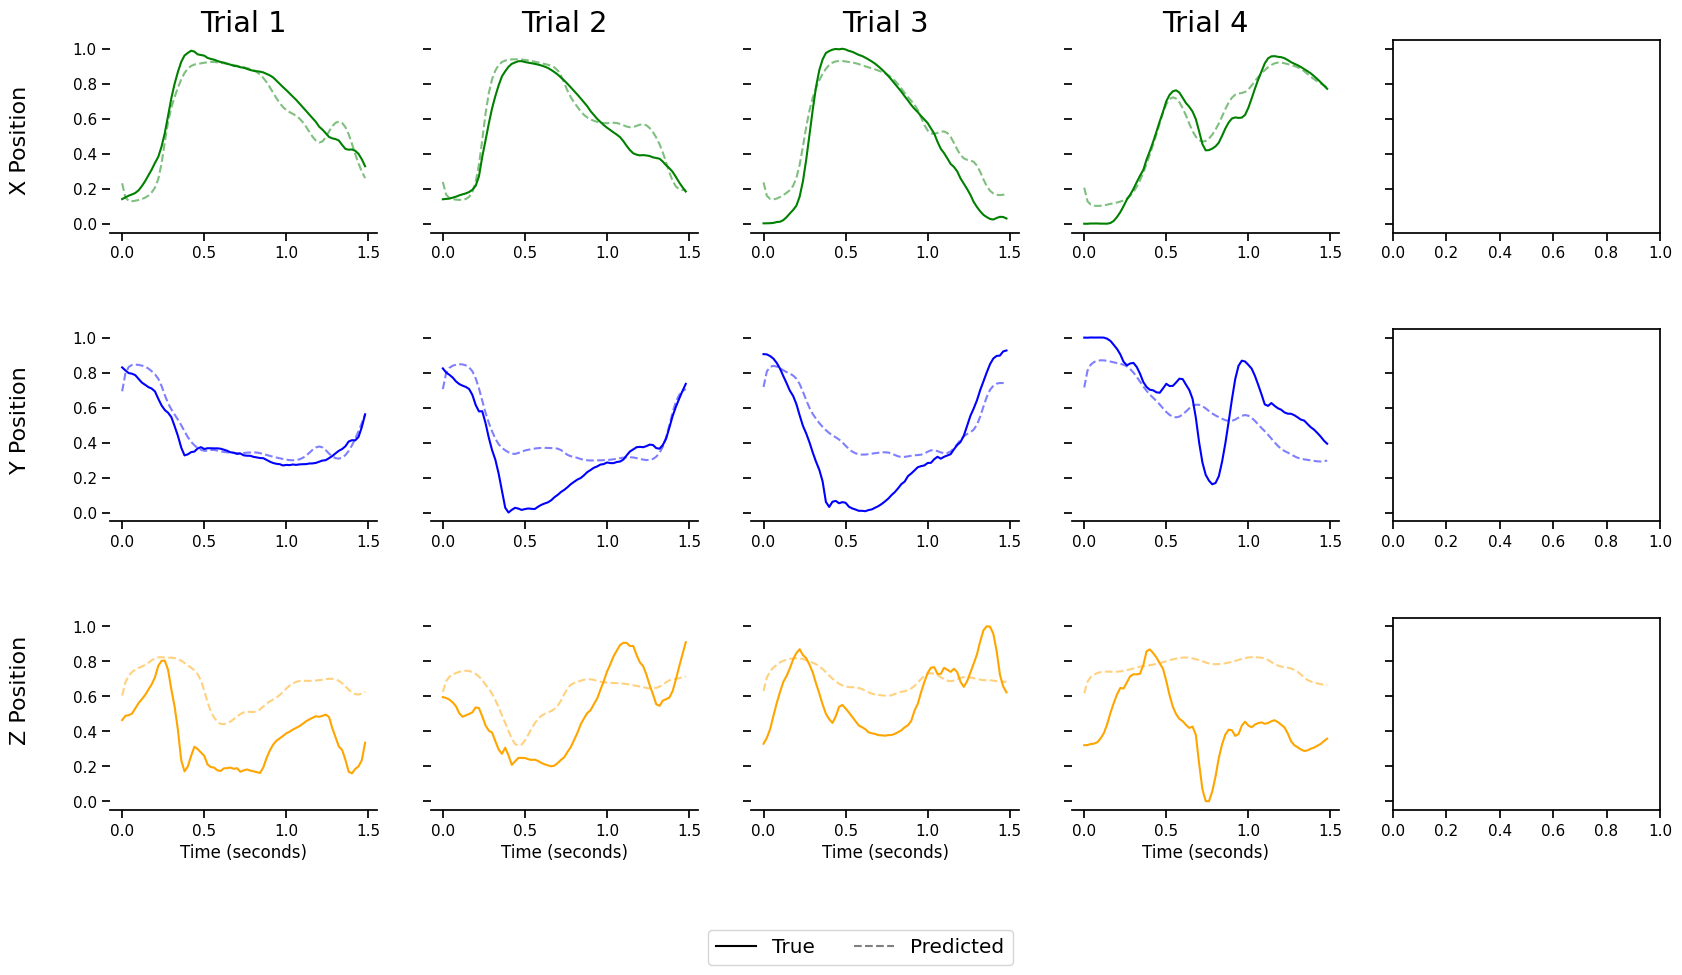

In [72]:
visualize_LSTM_test(y_hat, y_true, seq_length = 75)

## Training model only on stimulation data and testing on baseline data

In [73]:
X_train_stim, y_train_stim, X_val_stim,y_val_stim, X_test_stim, y_test_stim, info_train_stim,info_val_stim, info_test_stim = train_test_split(stim_df, train_variable = 'both_rates', 
                                                 target_variable = 'target_pos', num_folds = 5)


Test trials  8
Val trials 7


In [74]:
# Test one of the folds first
fold_num = 'fold1'
fold = 1

print('We are testing the model on fold ', fold)


X_train_stim = X_train_stim[fold_num]
X_val_stim = X_val_stim[fold_num]
X_test_stim = X_test_stim[fold_num]
y_test_stim = y_test_stim[fold_num]
y_train_stim = y_train_stim[fold_num]
y_val_stim = y_val_stim[fold_num]


# Specify that we want our tensors on the GPU and in float32
device = torch.device('cpu') #suposed to be cuda
dtype = torch.float32
path_to_models = './Models'

num_dim_output = y_train_stim.shape[1]
num_features = X_train_stim.shape[1]

seq_length = 75

# Reshape x_train to match the number of columns in the model's input layer
xx_train = X_train_stim.reshape(X_train_stim.shape[0] // seq_length, seq_length, X_train_stim.shape[1])  
# Reshape y_train to match the number of neurons in the model's output layer
yy_train = y_train_stim.reshape(y_train_stim.shape[0] // seq_length, seq_length, y_train_stim.shape[1])  

xx_val = X_val_stim.reshape(X_val_stim.shape[0] // seq_length, seq_length, X_val_stim.shape[1])  
yy_val = y_val_stim.reshape(y_val_stim.shape[0] // seq_length, seq_length, y_val_stim.shape[1])  

xx_test = X_test_stim.reshape(X_test_stim.shape[0] // seq_length, seq_length, X_test_stim.shape[1])  
yy_test = y_test_stim.reshape(y_test_stim.shape[0] // seq_length, seq_length, y_test_stim.shape[1])  

We are testing the model on fold  1


In [75]:
## Hyperparameters from Optuna

n_hidden_units = 32
num_layers = 5
input_size_LSTM = 31
dropout_1 = 0.45353387311567006
dropout_2 = 0.43469775095920277
lr = 0.0017186636685695396
lr_gamma = 1.4869841187864843
seq_length_LSTM = 17
batch_size_train = 33
batch_size_val = 34
huber_delta = 7
alpha_reg = 6.5952774295107e-06
l1_ratio_reg = 0.38894691744111975


In [76]:
# Fit the LSTM model
model = CausalTemporalLSTM(num_features=num_features, 
                    hidden_units= hidden_units, #was 128
                    num_layers = num_layers, 
                    input_size = input_size,
                    out_dims = num_dim_output, 
                    dropout_1 = dropout_1, 
                    dropout_2 = dropout_2).to(device)

def weight_reset(m):
    reset_parameters = getattr(m, "reset_parameters", None)
    if callable(reset_parameters):
        m.reset_parameters()

model.apply(weight_reset)

CausalTemporalLSTM(
  (lstm): LSTM(50, 43, num_layers=5, batch_first=True)
  (linear1): Linear(in_features=127, out_features=50, bias=True)
  (linear2): Linear(in_features=43, out_features=3, bias=True)
  (dropout1): Dropout(p=0.45353387311567006, inplace=False)
  (dropout2): Dropout(p=0.43469775095920277, inplace=False)
)

In [77]:
train_losses, val_losses = \
    train_model(model, xx_train,yy_train,
                xx_val, 
                yy_val,
                lr= lr,
                lr_step_size=lr_step_size,
                lr_gamma= lr_gamma,
                sequence_length_LSTM=seq_length_LSTM,
                batch_size_train = batch_size_train,
                batch_size_val = batch_size_val,
                num_epochs=1000, 
                delta = 8,                 
                regularizer=Reg,
                l1_ratio = 0.5,
                alpha = 1e-5,     
                early_stop = 5,
                
                )

Epoch 000 Train 0.0188 Val 0.0179
Epoch 001 Train 0.0117 Val 0.0185
Epoch 002 Train 0.0105 Val 0.0181
Epoch 003 Train 0.0092 Val 0.0161
Epoch 004 Train 0.0079 Val 0.0150
Epoch 005 Train 0.0072 Val 0.0150
Epoch 006 Train 0.0061 Val 0.0138
Epoch 007 Train 0.0046 Val 0.0119
Epoch 008 Train 0.0038 Val 0.0125
Epoch 009 Train 0.0034 Val 0.0120
Epoch 010 Train 0.0032 Val 0.0126
Epoch 011 Train 0.0029 Val 0.0133
Epoch 012 Train 0.0026 Val 0.0130
Epoch 013 Train 0.0023 Val 0.0135
Epoch 014 Train 0.0021 Val 0.0135
Decrease LR
Epoch 015 Train 0.0019 Val 0.0145
Epoch 016 Train 0.0017 Val 0.0142
Epoch 017 Train 0.0016 Val 0.0141
Epoch 018 Train 0.0016 Val 0.0141
Epoch 019 Train 0.0015 Val 0.0141
Decrease LR


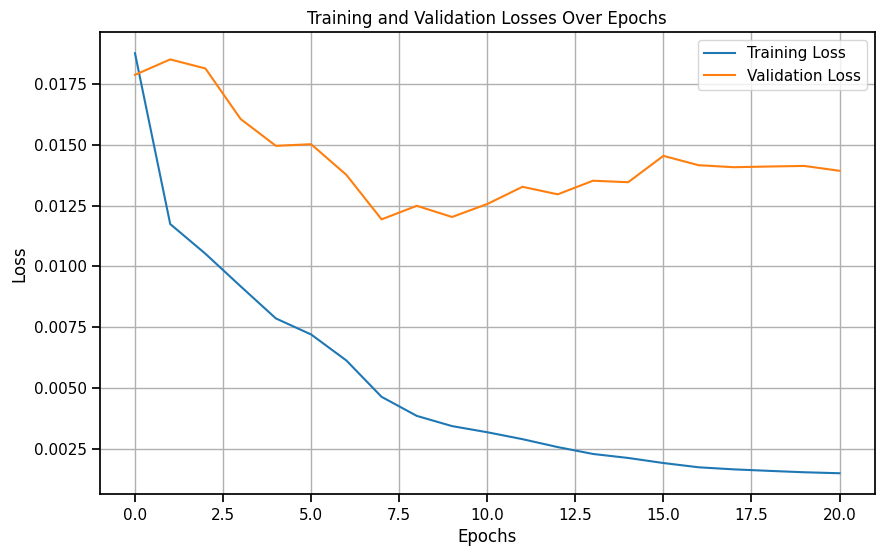

In [78]:
# Assuming you have already trained your model and collected the losses
# train_losses and val_losses are numpy arrays containing losses for each epoch
plot_losses(train_losses, val_losses)

In [79]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train, yy_train, xx_val, yy_val, xx_test, yy_test, model, metric = 'ev')

Train EV: 0.81 
Val EV: 0.66 
Test EV: 0.63 


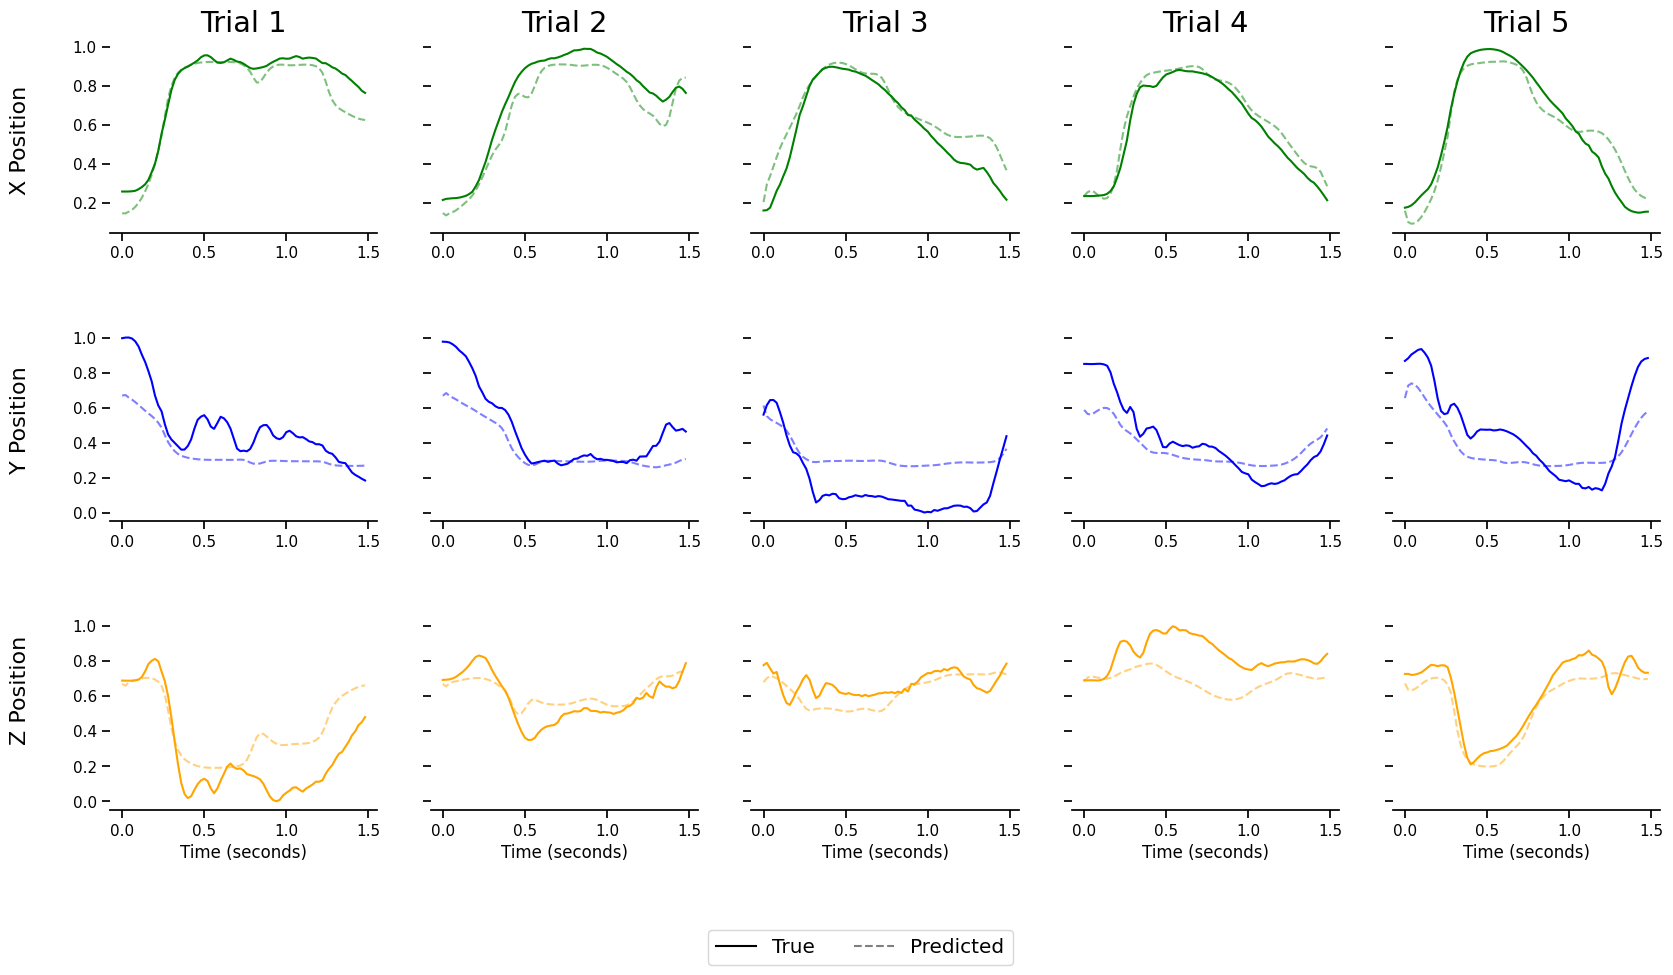

In [80]:
visualize_LSTM_test(y_hat, y_true, seq_length = 75)

In [81]:
path_to_models = './Models'
experiment_name = 'LSTM_fold0_20180413_Stim'
path_to_save_model = os.path.join(path_to_models,experiment_name)
if not os.path.exists(path_to_save_model):
            os.makedirs(path_to_save_model)
path_to_save_model_fold = os.path.join(path_to_save_model,'fold_{}.pth'.format(fold))
torch.save(model, path_to_save_model_fold)

### Now test on baseline data to compare to the EWC

In [82]:
model_stim = torch.load(path_to_save_model_fold)

In [83]:
model_stim.eval()

CausalTemporalLSTM(
  (lstm): LSTM(50, 43, num_layers=5, batch_first=True)
  (linear1): Linear(in_features=127, out_features=50, bias=True)
  (linear2): Linear(in_features=43, out_features=3, bias=True)
  (dropout1): Dropout(p=0.45353387311567006, inplace=False)
  (dropout2): Dropout(p=0.43469775095920277, inplace=False)
)

In [84]:
X_train, y_train, X_val, y_val, X_test, y_test, info_train, info_val, info_test = train_test_split(baseline_df, train_variable = 'both_rates', 
                                                 target_variable = 'target_pos', num_folds = 5)

Test trials  4
Val trials 3


In [85]:
# Test one of the folds first
fold_num = 'fold0'
fold = 0

print('We are testing the model on fold ', fold)


X_train = X_train[fold_num]
X_val = X_val[fold_num]
X_test = X_test[fold_num]
y_test = y_test[fold_num]
y_train = y_train[fold_num]
y_val = y_val[fold_num]


# Specify that we want our tensors on the GPU and in float32
device = torch.device('cpu') #suposed to be cuda
dtype = torch.float32
path_to_models = './Models'

num_dim_output = y_train.shape[1]
num_features = X_train.shape[1]

seq_length = 75

# Reshape x_train to match the number of columns in the model's input layer
xx_train = X_train.reshape(X_train.shape[0] // seq_length, seq_length, X_train.shape[1])  
# Reshape y_train to match the number of neurons in the model's output layer
yy_train = y_train.reshape(y_train.shape[0] // seq_length, seq_length, y_train.shape[1])  

xx_val = X_val.reshape(X_val.shape[0] // seq_length, seq_length, X_val.shape[1])  
yy_val = y_val.reshape(y_val.shape[0] // seq_length, seq_length, y_val.shape[1])  

xx_test = X_test.reshape(X_test.shape[0] // seq_length, seq_length, X_test.shape[1])  
yy_test = y_test.reshape(y_test.shape[0] // seq_length, seq_length, y_test.shape[1])  

We are testing the model on fold  0


In [86]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train, yy_train, xx_val, yy_val, xx_test, yy_test, model_stim, metric = 'ev')

Train EV: 0.61 
Val EV: 0.62 
Test EV: 0.52 


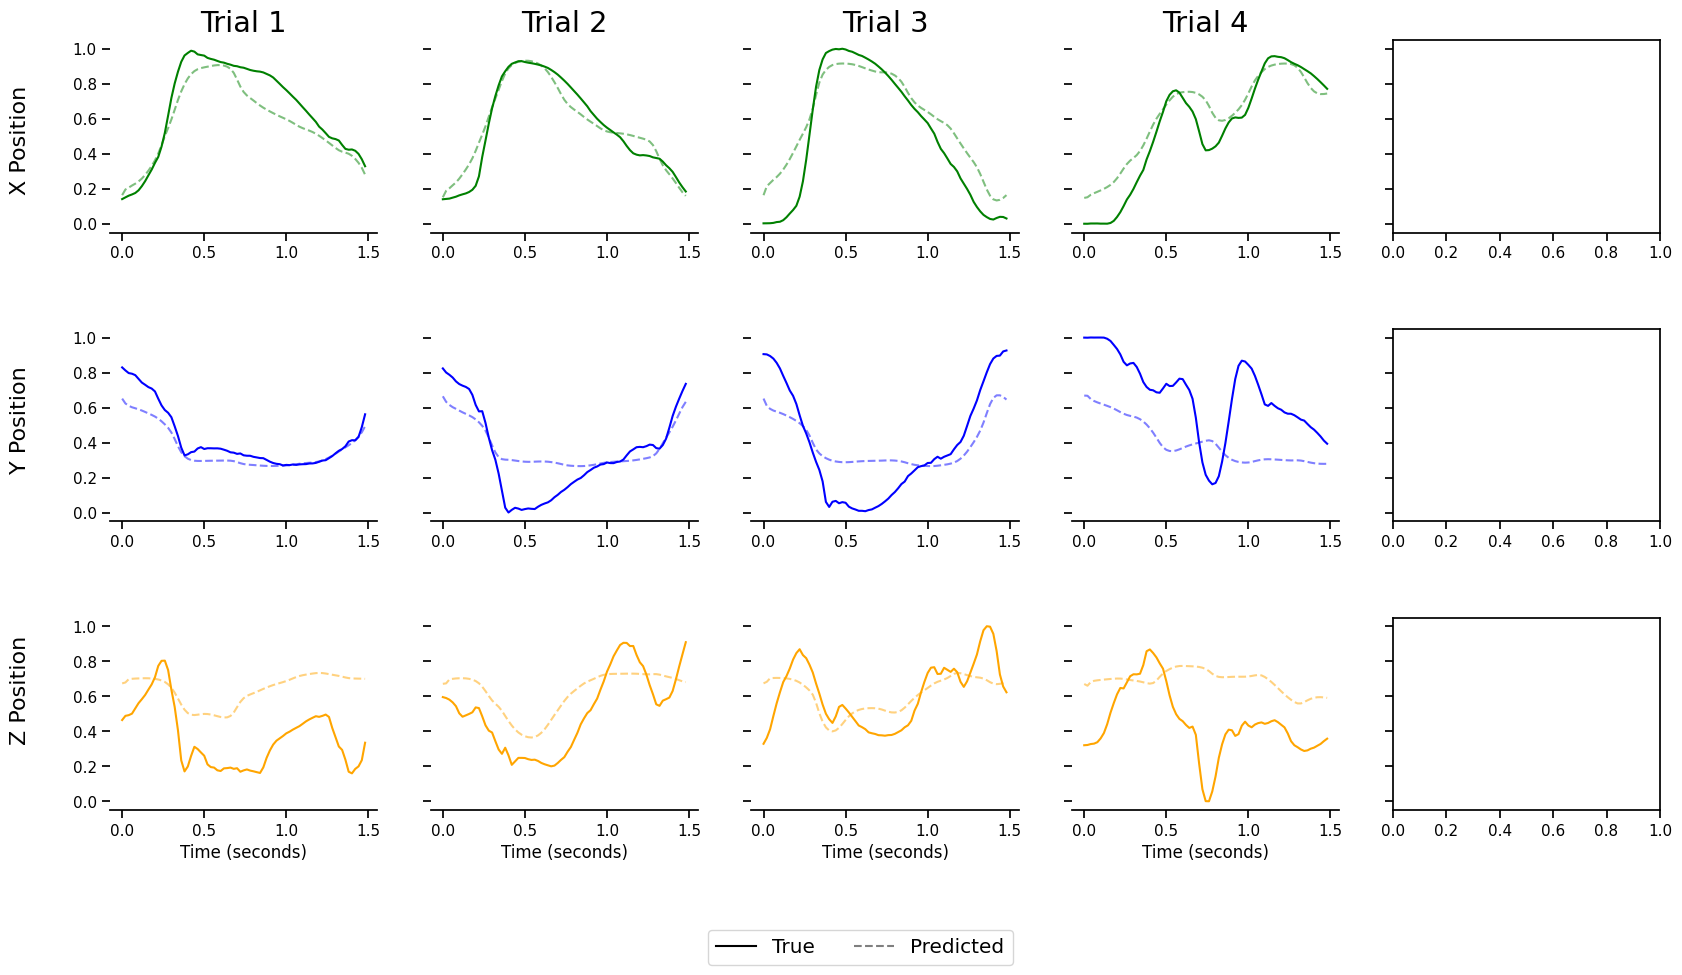

In [87]:
visualize_LSTM_test(y_hat, y_true, seq_length = 75)